# Introduction of the project

1. Project Name: Penang Property Price Prediction Regression (Residential)
2. Deliverable: Deployed Streamlit Web app
3. Machine Learning Task: Regression
4. Target Variable: Price (RM)
5. Input Features: Refer to Data Dictionary
6. Win Condition: Best Possible Model

In Summary:

The topic of this project is to predict the penang house price by multiple variables. All the data is extract from the mudah.com.my by their API.

### 0.0 Library Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

## Pickle for saving model files
import pickle

## Import Regularized Regression Algorithms
from sklearn.linear_model import Lasso, Ridge, ElasticNet

## Import Tree Ensemble Algos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

## Import xgboost
import xgboost as xgb

## MLP Algorithms
from sklearn.neural_network import MLPRegressor

## Splitting training and test set
from sklearn.model_selection import train_test_split

## One hot encoding
from sklearn.preprocessing import OneHotEncoder

## Model Pipelines
from sklearn.pipeline import make_pipeline

## StandardScaler
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

## GridSearchCV
from sklearn.model_selection import GridSearchCV

## Performance metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

## for some statistics
from scipy import stats
from scipy.stats import norm, skew

In [2]:
!pip insta

## 1.0 Exploratory Analysis

### 1.1 Basic Informations

In [3]:
df = pd.read_csv("mudah_property_data.csv", index_col = "Unnamed: 0")

df.head()

subarea_name            category_name        sub_category_name  \
0           Relau  Apartment / Condominium                Apartment   
1  Permatang Pauh                     Land              Residential   
2  Bukit Mertajam  Apartment / Condominium                Apartment   
3     Bayan Lepas  Apartment / Condominium              Condominium   
4          Bertam                    House  2-storey Terraced House   

  room_count bathroom_count  parking_count  size (sqrt) property_type  \
0          3              2              0        680.0      Freehold   
1          0              0              0      12545.0      Freehold   
2          3              2              2        883.0      Freehold   
3          4              2              2       1140.0      Freehold   
4          4              3              0       1480.0      Freehold   

   price (RM)  
0      270000  
1      390000  
2      378000  
3      663900  
4      434999

In [4]:
df.shape

(9999, 9)

In [5]:
df.dtypes

subarea_name          object
category_name         object
sub_category_name     object
room_count            object
bathroom_count        object
parking_count          int64
size (sqrt)          float64
property_type         object
price (RM)             int64
dtype: object

In [6]:
df["room_count"].value_counts()

3               4857
4               2226
5                970
0                910
2                480
6                359
7                 81
1                 78
8                 21
More than 10       8
10                 6
9                  3
Name: room_count, dtype: int64

In [7]:
df["bathroom_count"].value_counts()

2               4988
3               2043
0                910
4                768
5                514
1                475
6                194
7                 74
8                 14
More than 10      10
9                  7
10                 2
Name: bathroom_count, dtype: int64

**"room_count"** &  **bathroom_count** need to be augmented to become integer type column.

### 1.2 Distributions of Numeric Features

In [8]:
## Convert the room_count int by change the more than 10 to 10
df["room_count"] = df["room_count"].apply(lambda x : "10" if x == "More than 10" else x)
df["room_count"] = df["room_count"].astype("int64")

## Convert the bathroom_count int by change the more than 10 to 10
df["bathroom_count"] = df["bathroom_count"].apply(lambda x : "10" if x == "More than 10" else x)
df["bathroom_count"] = df["bathroom_count"].astype("int64")

df.describe()

room_count  bathroom_count  parking_count   size (sqrt)    price (RM)
count  9999.000000     9999.000000    9999.000000  9.999000e+03  9.999000e+03
mean      3.242224        2.420142       0.766177  2.694398e+03  1.599597e+06
std       1.426583        1.366152       0.972482  1.555248e+04  9.944377e+06
min       0.000000        0.000000       0.000000  3.000000e-02  4.000000e+00
25%       3.000000        2.000000       0.000000  9.000000e+02  4.000000e+05
50%       3.000000        2.000000       0.000000  1.338000e+03  6.300000e+05
75%       4.000000        3.000000       2.000000  2.450000e+03  1.200000e+06
max      10.000000       10.000000      10.000000  1.200000e+06  6.600000e+08

There is very small value in **"size(sqrt)"** which is impossible for a house

<function matplotlib.pyplot.show(close=None, block=None)>

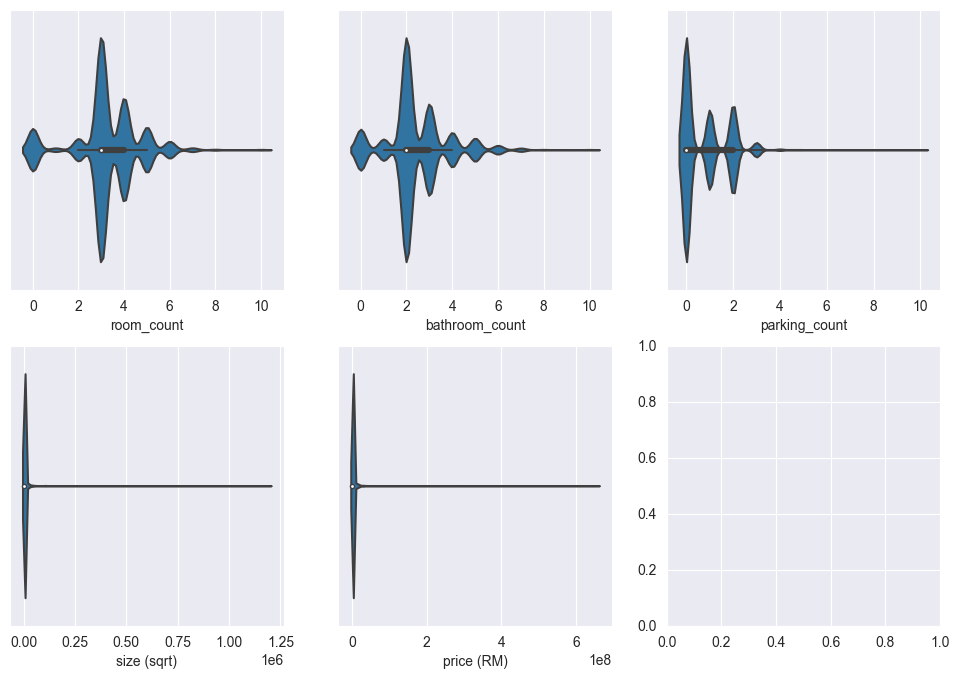

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

sns.violinplot(x="room_count", data=df, ax=axs[0][0], scale="count")
sns.violinplot(x="bathroom_count", data=df, ax=axs[0][1], scale="count")
sns.violinplot(x="parking_count", data=df, ax=axs[0][2], scale="count")

sns.violinplot(x="size (sqrt)", data=df, ax=axs[1][0], scale="count")
sns.violinplot(x="price (RM)", data=df, ax=axs[1][1], scale="count")

plt.show

Seem like there is outliers in **"size (sqrt)"** & **"price (RM)"**, we may need to do something during the data cleaning section

#### Check & Answer

1. Do each of the distributions make intuitive sense to you? **No, especially for the size (sqrt) and price (RM)**
2. Are they any surprising distributions you should take a closer look at? **Yes, especially for the size (sqrt) and price (RM)**
3. Do the summary statistics confirm what you've seen from the charts? **Yes**

### 1.3 Distributions of Categorical Features

In [10]:
df.describe(include=["object"])

subarea_name            category_name sub_category_name property_type
count          9999                     9999              9999          9999
unique           66                        4                31             2
top     Bayan Lepas  Apartment / Condominium       Condominium      Freehold
freq           1007                     5369              3477          8960

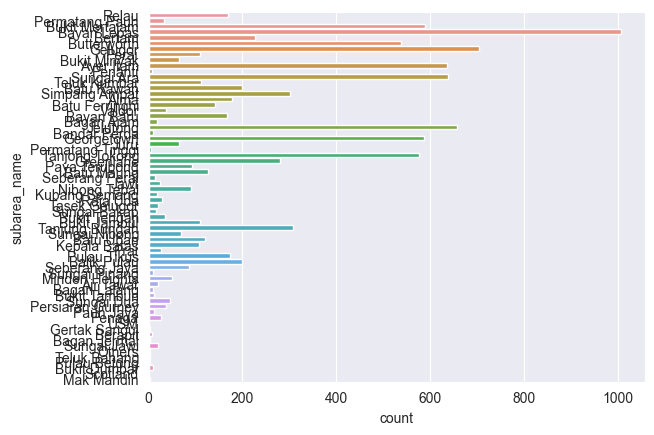

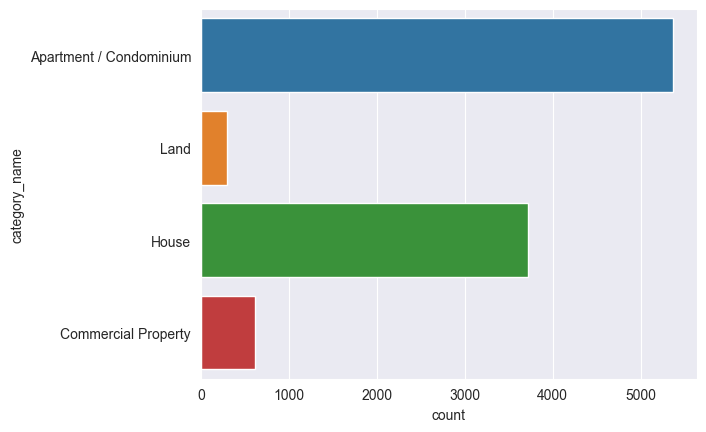

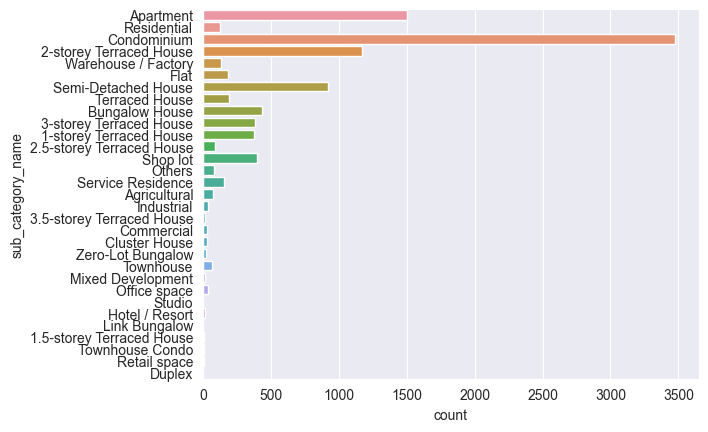

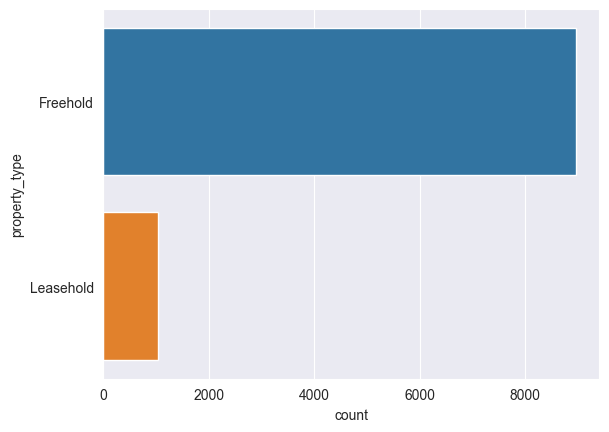

In [11]:
for feature in df.dtypes[df.dtypes == "object"].index:
    sns.countplot(y=feature, data=df)
    plt.show()

There is too much categorical in the **"subarea_name"** and **"sub_category_name"**

In [12]:
for index in df.dtypes[df.dtypes == "object"].index:
    print(index, ":", len(df[index].unique()))


subarea_name : 66
category_name : 4
sub_category_name : 31
property_type : 2


We may need to have to dimension reduction for the categorical features
    

### Check & Answer

1. Are there any classess that might be sparse? **No**
2. Are there any classess that shouldn't be in dataset based on our project scope? Yes,we can remove **"sub_category_name"**
3. Are there any mislabeled classes? **No**
4. Are the distributions seem intuitive? **Yes**

## 1.4 Segmentation

In [13]:
df.head()

subarea_name            category_name        sub_category_name  \
0           Relau  Apartment / Condominium                Apartment   
1  Permatang Pauh                     Land              Residential   
2  Bukit Mertajam  Apartment / Condominium                Apartment   
3     Bayan Lepas  Apartment / Condominium              Condominium   
4          Bertam                    House  2-storey Terraced House   

   room_count  bathroom_count  parking_count  size (sqrt) property_type  \
0           3               2              0        680.0      Freehold   
1           0               0              0      12545.0      Freehold   
2           3               2              2        883.0      Freehold   
3           4               2              2       1140.0      Freehold   
4           4               3              0       1480.0      Freehold   

   price (RM)  
0      270000  
1      390000  
2      378000  
3      663900  
4      434999

In [14]:
df.dtypes[df.dtypes == "object"]

subarea_name         object
category_name        object
sub_category_name    object
property_type        object
dtype: object

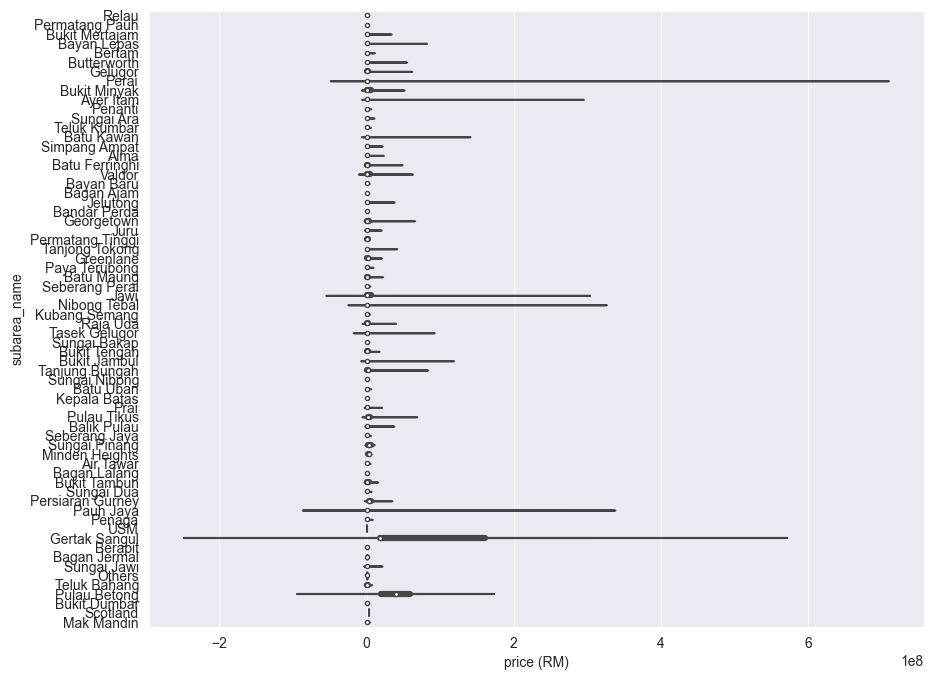

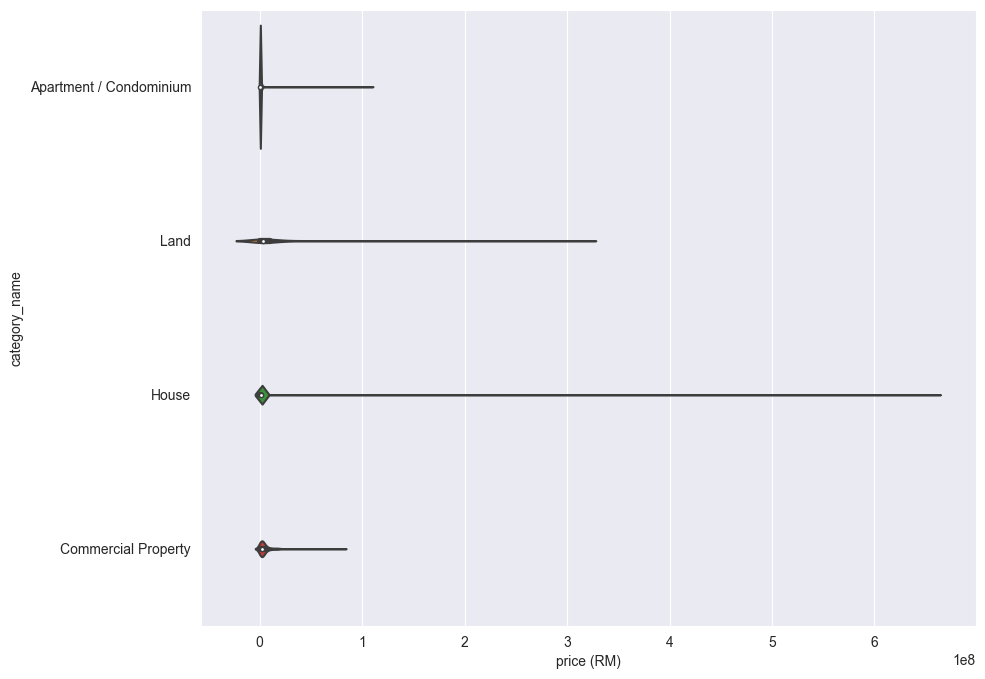

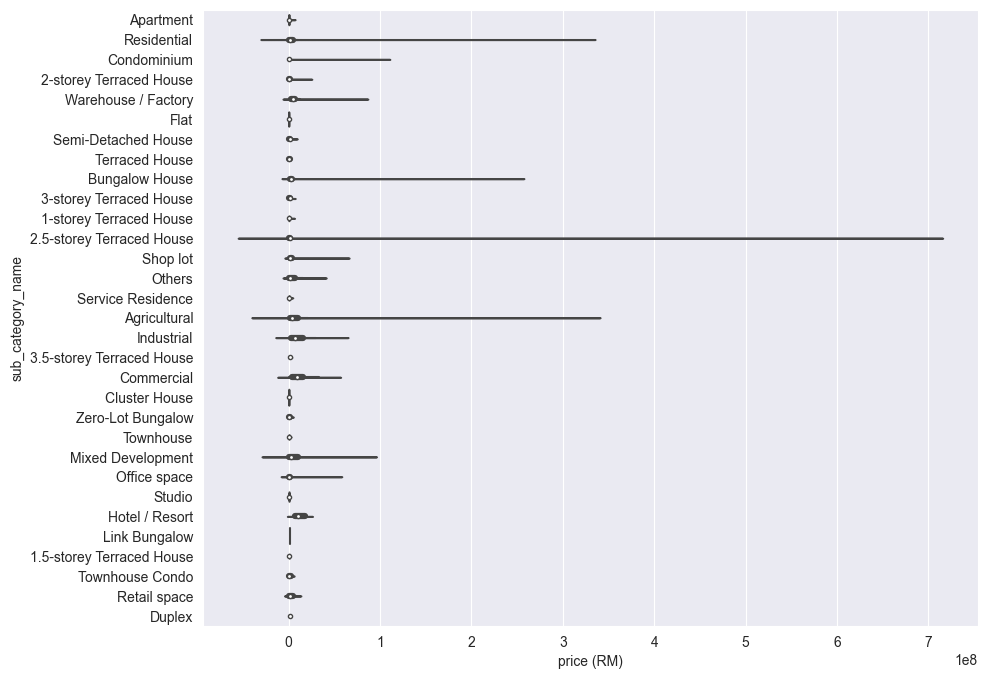

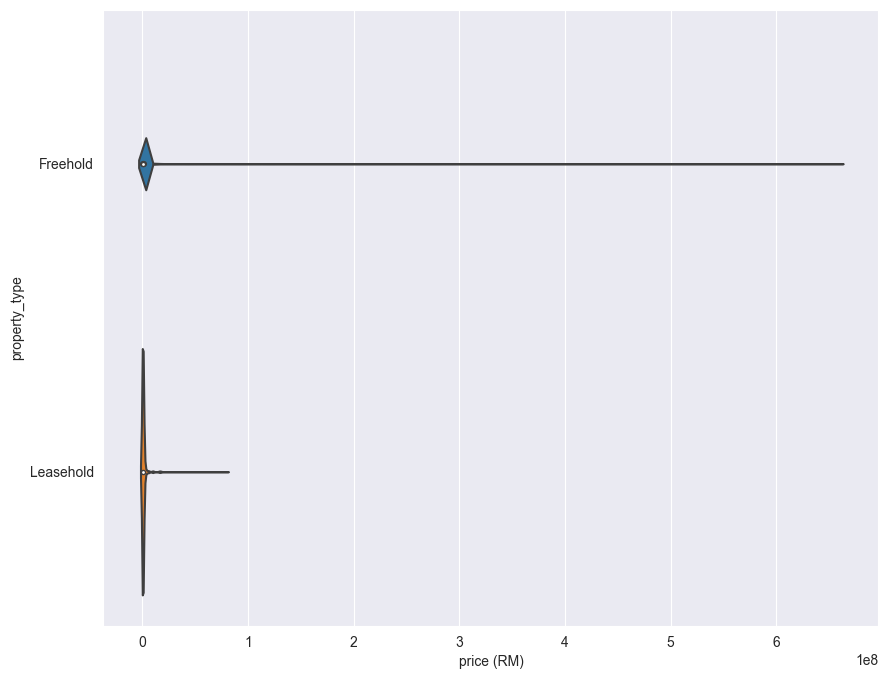

In [15]:
for feature in df.dtypes[df.dtypes == "object"].index:
    plt.figure(figsize=(10,8))
    sns.violinplot(x="price (RM)", y=feature, data=df)
    plt.show()

## 1.5 Correlations

In [16]:
correlations = df.corr()

In [17]:
correlations

room_count  bathroom_count  parking_count  size (sqrt)  \
room_count        1.000000        0.876832      -0.029897    -0.036992   
bathroom_count    0.876832        1.000000      -0.041008    -0.011279   
parking_count    -0.029897       -0.041008       1.000000    -0.064447   
size (sqrt)      -0.036992       -0.011279      -0.064447     1.000000   
price (RM)       -0.076635       -0.038679      -0.063286     0.061667   

                price (RM)  
room_count       -0.076635  
bathroom_count   -0.038679  
parking_count    -0.063286  
size (sqrt)       0.061667  
price (RM)        1.000000

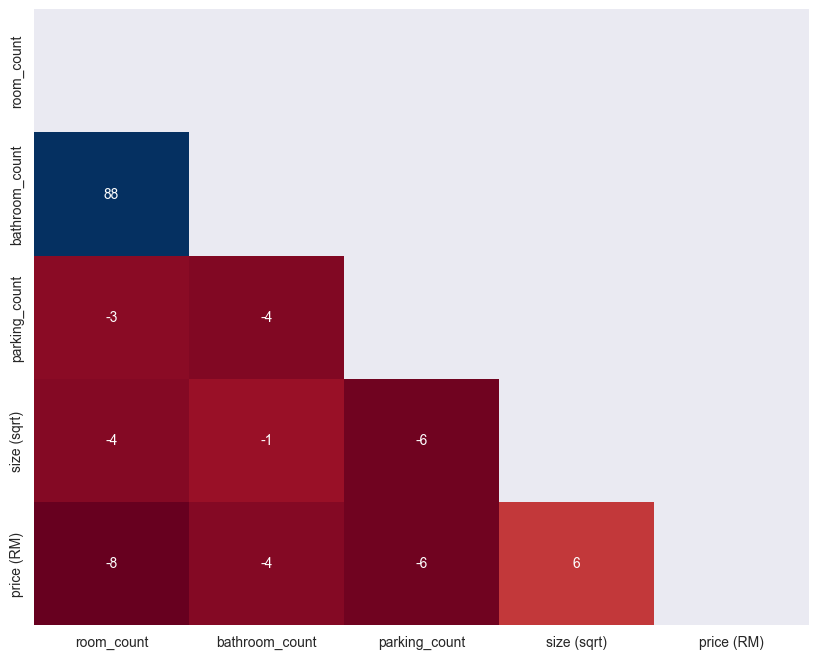

In [18]:
## Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

plt.figure(figsize=(10,8))

sns.heatmap(correlations * 100, 
            cmap="RdBu", 
            annot=True, 
            fmt=".0f", 
            mask=mask,
            cbar=False
           )

plt.show()

* "bathroom_count" and "room_count" has strong positive correlation

**We may need to drop either one in the feature engineering, as strong correlation between 2 variables lead to similar pattern and knowledge significantly reduce the performance**

## 2.0 Data Cleaning

### 2.1 Drop Unwanted Observations

In [19]:
df.shape

(9999, 9)

In [20]:
df = df.drop_duplicates()

df.shape

(7743, 9)

In [21]:
for index in df.dtypes[df.dtypes == "object"].index:
    print(index, ":", len(df[index].unique()))

subarea_name : 66
category_name : 4
sub_category_name : 31
property_type : 2


In [22]:
## Since we are only to predict the residential price, we shall exclude non-residential category from the "category_name"
## "sub_category_name" will be drop completely in the feature engineering section as we have "category_name"
## ['Apartment / Condominium', 'Land', 'House', 'Commercial Property']

residential_filter = (df["category_name"] == "Apartment / Condominium") | (df["category_name"] == "House")

df = df[residential_filter].reset_index(drop=True)

In [23]:
df.shape

(6916, 9)

### 2.2 Fix Structural Errors

In [24]:
df.head()

subarea_name            category_name        sub_category_name  \
0           Relau  Apartment / Condominium                Apartment   
1  Bukit Mertajam  Apartment / Condominium                Apartment   
2     Bayan Lepas  Apartment / Condominium              Condominium   
3          Bertam                    House  2-storey Terraced House   
4     Butterworth  Apartment / Condominium                Apartment   

   room_count  bathroom_count  parking_count  size (sqrt) property_type  \
0           3               2              0        680.0      Freehold   
1           3               2              2        883.0      Freehold   
2           4               2              2       1140.0      Freehold   
3           4               3              0       1480.0      Freehold   
4           3               2              1        860.0      Freehold   

   price (RM)  
0      270000  
1      378000  
2      663900  
3      434999  
4      450000

In [25]:
df.isnull().sum()

subarea_name         0
category_name        0
sub_category_name    0
room_count           0
bathroom_count       0
parking_count        0
size (sqrt)          0
property_type        0
price (RM)           0
dtype: int64

There is no null values in the dataset

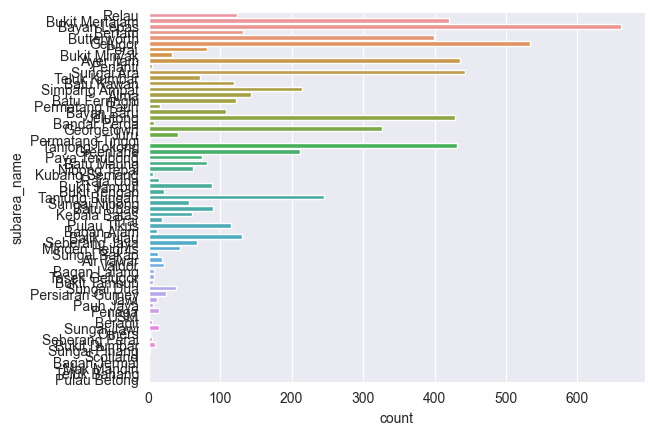

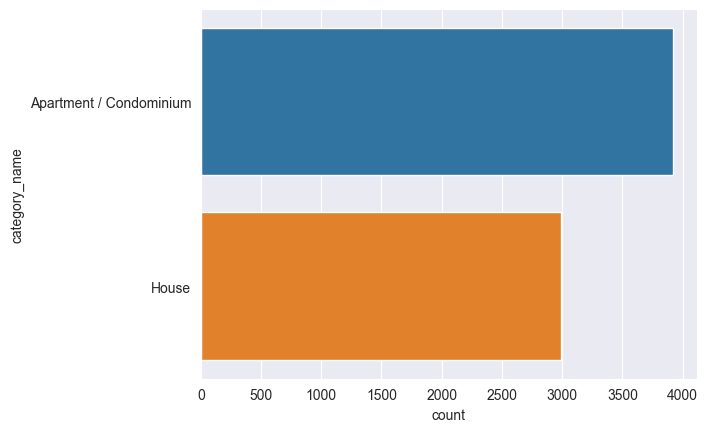

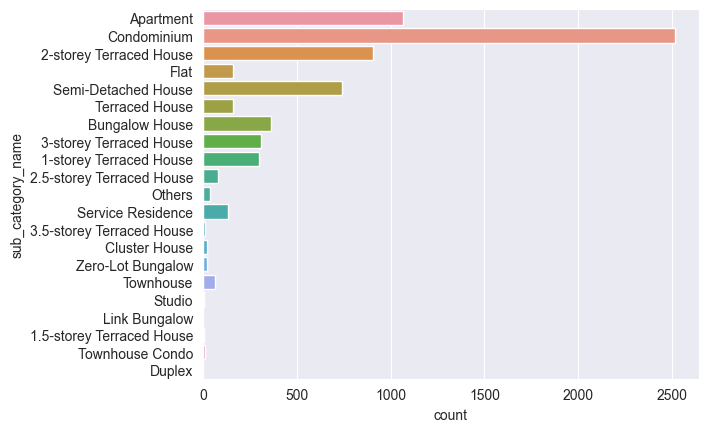

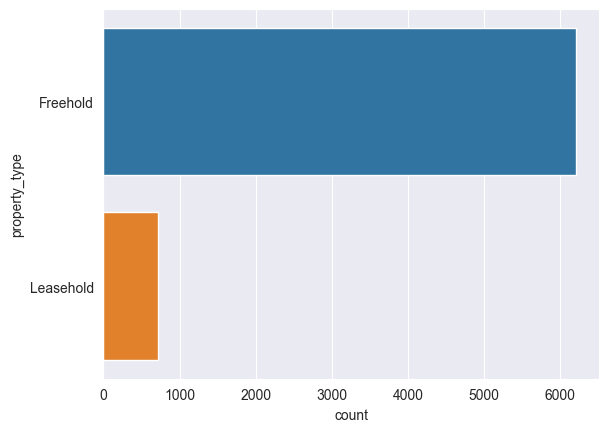

In [26]:
## Quick look on any typos or inconsistent capitalization
for feature in df.dtypes[df.dtypes == "object"].index:
    sns.countplot(y=feature, data=df)
    plt.show()

Seem likes there isn't any typos or inconsistent capization in the dataset. But further feature engineering need to be done in this dataset.

### 2.3 Capping "Guilty Outlier"

In [27]:
df.dtypes[df.dtypes != "object"]

room_count          int64
bathroom_count      int64
parking_count       int64
size (sqrt)       float64
price (RM)          int64
dtype: object

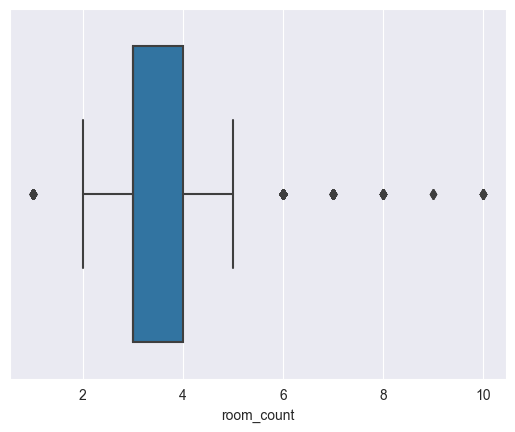

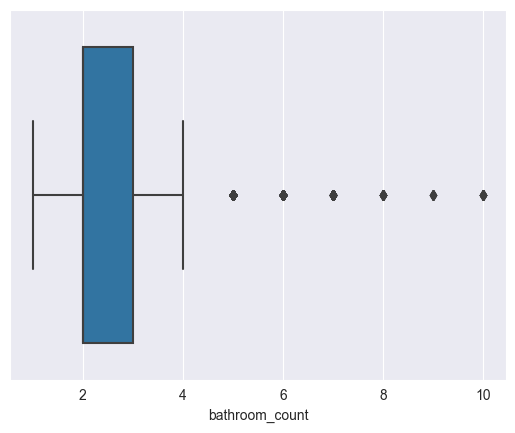

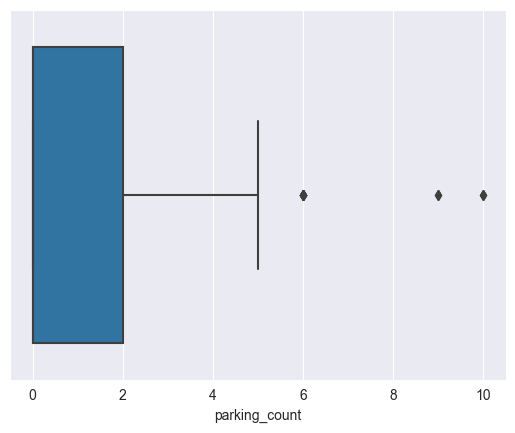

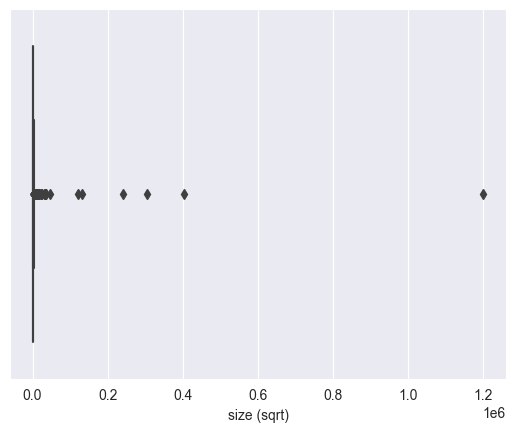

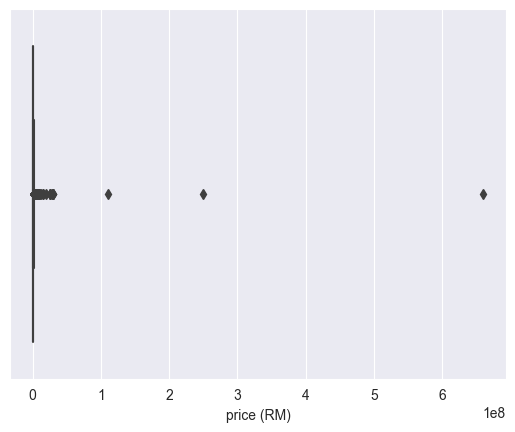

In [28]:
for feature in df.dtypes[df.dtypes != "object"].index:
    sns.boxplot(x=df[feature])
    plt.show()

In [29]:
## Caping Outlier Function
def cap_data(df):
    for col in df.dtypes[df.dtypes != "object"].index:
        print("capping the ",col)
        percentiles = df[col].quantile([0.25,0.75]).values
        df[col][df[col] <= percentiles[0]] = percentiles[0]
        df[col][df[col] >= percentiles[1]] = percentiles[1]

    return df

df = cap_data(df)

capping the  room_count
capping the  bathroom_count
capping the  parking_count
capping the  size (sqrt)
capping the  price (RM)


C:\Users\nicky\AppData\Local\Temp\ipykernel_6344\3015133242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
C:\Users\nicky\AppData\Local\Temp\ipykernel_6344\3015133242.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] >= percentiles[1]] = percentiles[1]


In [30]:
## Removal Outlier Function
# cols = df.dtypes[df.dtypes != "object"].index.tolist() # one or more

# Q1 = df[cols].quantile(0.25)
# Q3 = df[cols].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [31]:
df.describe()

room_count  bathroom_count  parking_count  size (sqrt)    price (RM)
count  6916.000000     6916.000000    6916.000000  6916.000000  6.916000e+03
mean      3.427704        2.417004       0.735107  1559.203152  6.939913e+05
std       0.494781        0.493099       0.855480   593.308218  2.758415e+05
min       3.000000        2.000000       0.000000   938.000000  3.990000e+05
25%       3.000000        2.000000       0.000000   938.000000  3.990000e+05
50%       3.000000        2.000000       0.000000  1372.000000  6.180000e+05
75%       4.000000        3.000000       2.000000  2400.000000  1.080000e+06
max       4.000000        3.000000       2.000000  2400.000000  1.080000e+06

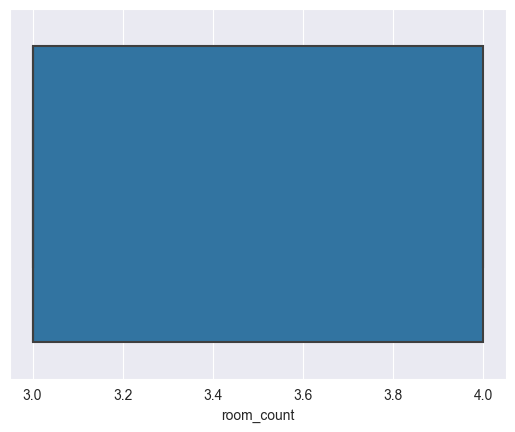

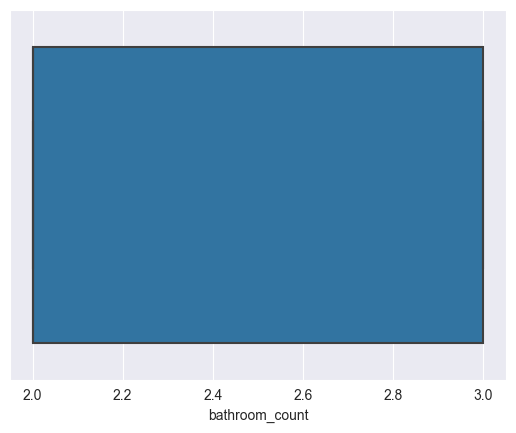

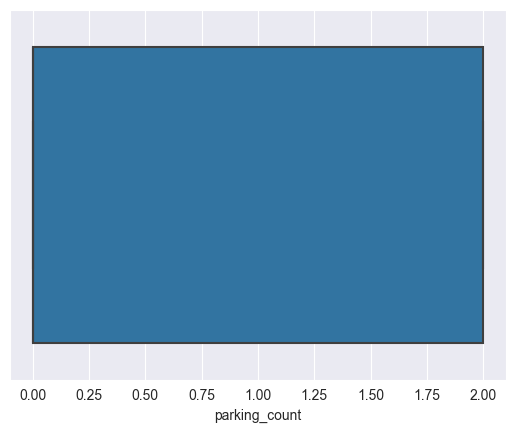

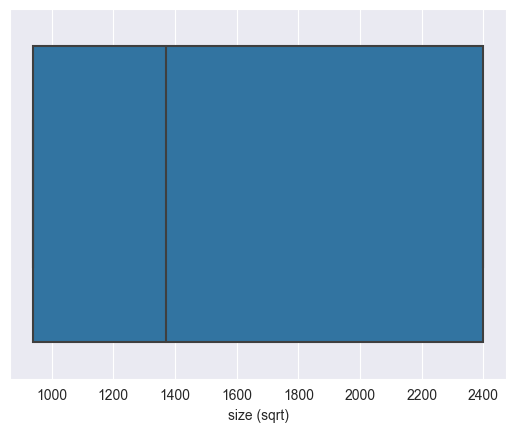

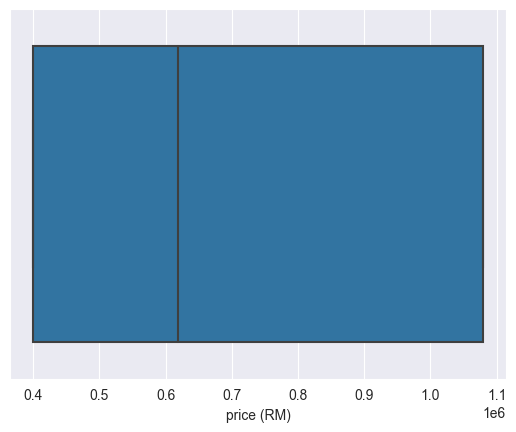

In [32]:
for feature in df.dtypes[df.dtypes != "object"].index:
    sns.boxplot(x=df[feature])
    plt.show()

### 2.4 Handle Missing Data

In [33]:
## Quick look on any missing data in numeric features
df.select_dtypes(exclude=["object"]).isnull().sum()

room_count        0
bathroom_count    0
parking_count     0
size (sqrt)       0
price (RM)        0
dtype: int64

In [34]:
## Quick look on any missing data in categorical features
df.select_dtypes(include=["object"]).isnull().sum()

subarea_name         0
category_name        0
sub_category_name    0
property_type        0
dtype: int64

We don't have any missing values for both numeric and categorical features

## 3.0 Feature Engineering

In [35]:
df.head()

subarea_name            category_name        sub_category_name  \
0           Relau  Apartment / Condominium                Apartment   
1  Bukit Mertajam  Apartment / Condominium                Apartment   
2     Bayan Lepas  Apartment / Condominium              Condominium   
3          Bertam                    House  2-storey Terraced House   
4     Butterworth  Apartment / Condominium                Apartment   

   room_count  bathroom_count  parking_count  size (sqrt) property_type  \
0           3               2              0        938.0      Freehold   
1           3               2              2        938.0      Freehold   
2           4               2              2       1140.0      Freehold   
3           4               3              0       1480.0      Freehold   
4           3               2              1        938.0      Freehold   

   price (RM)  
0      399000  
1      399000  
2      663900  
3      434999  
4      450000

### 3.1 Leverage Domain Knowledge

In [36]:
## "sub_category_name" will be removed from this dataframe as we already have categoryname
new_df = df.copy()
new_df = new_df.drop(["sub_category_name", "bathroom_count"], axis=1)

new_df.head()

subarea_name            category_name  room_count  parking_count  \
0           Relau  Apartment / Condominium           3              0   
1  Bukit Mertajam  Apartment / Condominium           3              2   
2     Bayan Lepas  Apartment / Condominium           4              2   
3          Bertam                    House           4              0   
4     Butterworth  Apartment / Condominium           3              1   

   size (sqrt) property_type  price (RM)  
0        938.0      Freehold      399000  
1        938.0      Freehold      399000  
2       1140.0      Freehold      663900  
3       1480.0      Freehold      434999  
4        938.0      Freehold      450000

In [37]:
## There is some weird value in the parking count, let check the value counts
new_df["parking_count"].value_counts()

0    3689
2    1857
1    1370
Name: parking_count, dtype: int64

More than 3000 of the property without parking! This is impossible!

In [38]:
## Since the 0 for parking_count is almost the half, we may drop this column as well
new_df = new_df.drop(["parking_count"], axis=1)

new_df.head()

subarea_name            category_name  room_count  size (sqrt)  \
0           Relau  Apartment / Condominium           3        938.0   
1  Bukit Mertajam  Apartment / Condominium           3        938.0   
2     Bayan Lepas  Apartment / Condominium           4       1140.0   
3          Bertam                    House           4       1480.0   
4     Butterworth  Apartment / Condominium           3        938.0   

  property_type  price (RM)  
0      Freehold      399000  
1      Freehold      399000  
2      Freehold      663900  
3      Freehold      434999  
4      Freehold      450000

In [39]:
## Let focus on the housing advertisement more than 50
new_df = new_df[new_df["subarea_name"].map(new_df["subarea_name"].value_counts()) >= 50]

### 3.2 Create Interaction Features

There is no intereaction features need to create for this dataset

In [40]:
## Group subarea_name to district of penang
northeast_penang_island = ["Gelugor", "Ayer Itam", "Tanjong Tokong", "Jelutong", "Georgetown", "Tanjung Bungah", "Greenlane", "Batu Ferringhi", 
                           "Pulau Tikus", "Batu Uban", "Bukit Jambul", "Paya Terubong", "Sungai Nibong", "Minden Heights", "Persiaran Gurney",
                           "Bukit Dumbar", "Tasek Gelugor", "Sungai Pinang", "USM", "Scotland"]
southwest_penang_island = ["Bayan Lepas", "Sungai Ara", "Balik Pulau", "Relau", "Bayan Baru", "Batu Maung", "Teluk Kumbar", "Teluk Bahang", "Pulau Betong"]
north_seberang_perai = ["Butterworth", "Bertam", "Kepala Batas", "Sungai Dua", "Air Tawar", "Penaga", "Raja Uda", "Bagan Ajam", "Bagan Lalang", 
                        "Seberang Perai", "Bagan Jesrmal"]
central_seberang_perai = ["Bukit Mertajam", "Alma", "Perai", "Seberang Jaya", "Juru", "Bukit Minyak", "Bukit Tengah", "Prai", "Permatang Pauh", 
                          "Bandar Perda", "Kubang Semang", "Pauh Jaya", "Berapit", "Penanti", "Permatang Tinggi", "Mak Mandin"]
south_seberang_perai = ["Simpang Ampat", "Batu Kawan", "Nibong Tebal", "Valdor", "Sungai Jawi", "Sungai Bakap", "Jawi", "Bukit Tambun"]
others = ["Others"]

## Group distric of penang to island and mainland
pg_island = ["North East Penang Island", "South West Penang Island"]
pg_mainland = ["North Seberang Perai", "Central Seberang Perai", "South Seberang Perai"]

## Function to group subarea_name to district
def check_subarea_name (x):
    if x in northeast_penang_island:
        return "North East Penang Island"
    elif x in southwest_penang_island:
        return "South West Penang Island"
    elif x in north_seberang_perai:
        return "North Seberang Perai"
    elif x in central_seberang_perai:
        return "Central Seberang Perai"
    elif x in south_seberang_perai:
        return "South Seberang Perai"
    else:
        return "Others"
    
def check_island_mainland (x):
    if x in pg_island:
        return "Island"
    else:
        return "Mainland"

In [41]:
new_df["district_penang"] = new_df["subarea_name"].apply(lambda x : check_subarea_name(x))

In [42]:
new_df.head()

subarea_name            category_name  room_count  size (sqrt)  \
0           Relau  Apartment / Condominium           3        938.0   
1  Bukit Mertajam  Apartment / Condominium           3        938.0   
2     Bayan Lepas  Apartment / Condominium           4       1140.0   
3          Bertam                    House           4       1480.0   
4     Butterworth  Apartment / Condominium           3        938.0   

  property_type  price (RM)           district_penang  
0      Freehold      399000  South West Penang Island  
1      Freehold      399000    Central Seberang Perai  
2      Freehold      663900  South West Penang Island  
3      Freehold      434999      North Seberang Perai  
4      Freehold      450000      North Seberang Perai

In [43]:
## Drop the others row
new_df = new_df[~new_df["district_penang"].isin(others)]

In [44]:
new_df["location_penang"] = new_df["district_penang"].apply(lambda x : check_island_mainland(x))

In [45]:
new_df.head()

subarea_name            category_name  room_count  size (sqrt)  \
0           Relau  Apartment / Condominium           3        938.0   
1  Bukit Mertajam  Apartment / Condominium           3        938.0   
2     Bayan Lepas  Apartment / Condominium           4       1140.0   
3          Bertam                    House           4       1480.0   
4     Butterworth  Apartment / Condominium           3        938.0   

  property_type  price (RM)           district_penang location_penang  
0      Freehold      399000  South West Penang Island          Island  
1      Freehold      399000    Central Seberang Perai        Mainland  
2      Freehold      663900  South West Penang Island          Island  
3      Freehold      434999      North Seberang Perai        Mainland  
4      Freehold      450000      North Seberang Perai        Mainland

### 3.3 Group Sparse Classes

There is no sparse classess need to be group

### 3.4 Feature Selection and Dimension Reduction

Later stage

### 3.5 Prepare Analytical Base Table

In [46]:
## reset index before one hot encoder to avoid NaN value

new_df = new_df.reset_index(drop=True)

In [47]:
## For predict model later
# new_df.to_csv('pre_abt.csv', index=False)

In [48]:
new_df.head()

subarea_name            category_name  room_count  size (sqrt)  \
0           Relau  Apartment / Condominium           3        938.0   
1  Bukit Mertajam  Apartment / Condominium           3        938.0   
2     Bayan Lepas  Apartment / Condominium           4       1140.0   
3          Bertam                    House           4       1480.0   
4     Butterworth  Apartment / Condominium           3        938.0   

  property_type  price (RM)           district_penang location_penang  
0      Freehold      399000  South West Penang Island          Island  
1      Freehold      399000    Central Seberang Perai        Mainland  
2      Freehold      663900  South West Penang Island          Island  
3      Freehold      434999      North Seberang Perai        Mainland  
4      Freehold      450000      North Seberang Perai        Mainland

In [49]:
new_df.describe()

room_count  size (sqrt)    price (RM)
count  6483.000000  6483.000000  6.483000e+03
mean      3.416628  1541.735153  6.944875e+05
std       0.493038   588.707164  2.758471e+05
min       3.000000   938.000000  3.990000e+05
25%       3.000000   938.000000  3.990000e+05
50%       3.000000  1336.000000  6.180000e+05
75%       4.000000  2314.000000  1.080000e+06
max       4.000000  2400.000000  1.080000e+06

In [50]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(categories = "auto", handle_unknown="ignore")

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(new_df[["subarea_name", "category_name", "property_type", "district_penang", "location_penang"]]).toarray())

#merge one-hot encoded columns back with original DataFrame
abt_df = new_df.join(encoder_df).drop(["subarea_name", "category_name", "property_type", "district_penang", "location_penang"], axis=1)

#view final df
abt_df

room_count  size (sqrt)  price (RM)    0    1    2    3    4    5    6  \
0              3        938.0      399000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1              3        938.0      399000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2              4       1140.0      663900  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3              4       1480.0      434999  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4              3        938.0      450000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...          ...          ...         ...  ...  ...  ...  ...  ...  ...  ...   
6478           4       2400.0      650000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6479           3        938.0      399000  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
6480           3        950.0      550000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6481           4       1623.0      899000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6482           4       1290.0      425000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        7    8    9   10   11   12   13   14   15   16   17   18   19   20  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
6478  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6479  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6480  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
6481  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6482  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

       21   22   23   24   25   26   27   28   29   30   31   32   33   34  \
0     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
6478  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
6479  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
6480  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
6481  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
6482  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   

       35   36   37   38   39   40  
0     0.0  0.0  0.0  1.0  1.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  1.0  
2     0.0  0.0  0.0  1.0  1.0  0.0  
3     0.0  1.0  0.0  0.0  0.0  1.0  
4     0.0  1.0  0.0  0.0  0.0  1.0  
...   ...  ...  ...  ...  ...  ...  
6478  0.0  0.0  1.0  0.0  0.0  1.0  
6479  1.0  0.0  0.0  0.0  1.0  0.0  
6480  1.0  0.0  0.0  0.0  1.0  0.0  
6481  0.0  0.0  0.0  1.0  1.0  0.0  
6482  0.0  1.0  0.0  0.0  0.0  1.0  

[6483 rows x 44 columns]

In [ ]:
# abt_df = pd.get_dummies(new_df, columns=["subarea_name", "category_name", "property_type", "district_penang", "location_penang"])

# abt_df

## 4.0 Algorithm Selection

We will use five algorithms for this project. Namely:

1. Lasso
2. Ridge
3. Elastic-Net
4. Random Forests
5. Gradient Boost
6. Ada Boost
7. XGBoost
8. Multi-layer Perceptron Regressor

## 5.0 Model Selection

### 5.1 Split Your Dataset

In [52]:
## Let's show the analytical base table dataframe
abt_df.head()

room_count  size (sqrt)  price (RM)  subarea_name_Alma  \
0           3        938.0      399000                  0   
1           3        938.0      399000                  0   
2           4       1140.0      663900                  0   
3           4       1480.0      434999                  0   
4           3        938.0      450000                  0   

   subarea_name_Ayer Itam  subarea_name_Balik Pulau  \
0                       0                         0   
1                       0                         0   
2                       0                         0   
3                       0                         0   
4                       0                         0   

   subarea_name_Batu Ferringhi  subarea_name_Batu Kawan  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   

   subarea_name_Batu Maung  subarea_name_Batu Uban  subarea_name_Bayan Baru  \
0                        0                       0                        0   
1                        0                       0                        0   
2                        0                       0                        0   
3                        0                       0                        0   
4                        0                       0                        0   

   subarea_name_Bayan Lepas  subarea_name_Bertam  subarea_name_Bukit Jambul  \
0                         0                    0                          0   
1                         0                    0                          0   
2                         1                    0                          0   
3                         0                    1                          0   
4                         0                    0                          0   

   subarea_name_Bukit Mertajam  subarea_name_Butterworth  \
0                            0                         0   
1                            1                         0   
2                            0                         0   
3                            0                         0   
4                            0                         1   

   subarea_name_Gelugor  subarea_name_Georgetown  subarea_name_Greenlane  \
0                     0                        0                       0   
1                     0                        0                       0   
2                     0                        0                       0   
3                     0                        0                       0   
4                     0                        0                       0   

   subarea_name_Jelutong  subarea_name_Kepala Batas  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      0                          0   
4                      0                          0   

   subarea_name_Nibong Tebal  subarea_name_Paya Terubong  subarea_name_Perai  \
0                          0                           0                   0   
1                          0                           0                   0   
2                          0                           0                   0   
3                          0                           0                   0   
4                          0                           0                   0   

   subarea_name_Pulau Tikus  subarea_name_Relau  subarea_name_Seberang Jaya  \
0                         0                   1                           0   
1                         0                   0                           0   
2                         0                   0                           0   
3                         0                   0       

In [53]:
## Create separate object for target variable
y = abt_df["price (RM)"]

## Create separate object for input features
X = abt_df.drop("price (RM)", axis=1)

In [54]:
## Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)

print(len(X_train), len(X_test), len(y_train), len(y_test))

5186 1297 5186 1297


### 5.2 Build Model Pipelines

In [55]:
pipelines = {
    "lasso" : make_pipeline(MinMaxScaler(), Lasso(random_state=1234)),
    "ridge" : make_pipeline(MinMaxScaler(), Ridge(random_state=123)),
    "enet" : make_pipeline(MinMaxScaler(), ElasticNet(random_state=1234)),
    "rf" : make_pipeline(MinMaxScaler(), RandomForestRegressor(random_state=123)),
    "gb" : make_pipeline(MinMaxScaler(), GradientBoostingRegressor(random_state=123)),
    "ad" : make_pipeline(MinMaxScaler(), AdaBoostRegressor(random_state=123)),
    "xgb" : make_pipeline(MinMaxScaler(), xgb.XGBRegressor(random_state=123)),
    "mlp" : make_pipeline(MinMaxScaler(), MLPRegressor(random_state=123))
}

### 5.3 Declare Hyperparameter Grids

In [56]:
## Regularized Linear Regression hyperparameters tuning
lasso_hyperparameters = {
    "lasso__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

ridge_hyperparameters = {
    "ridge__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

enet_hyperparameters = {
    "elasticnet__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
    "elasticnet__l1_ratio" : [0.1, 0.3, 0.5, 0.7, 0.9]
}

## Tree Ensemble hyperparameters tuning
rf_hyperparameters = {
    # "randomforestregressor__max_depth" : [80, 90, 100 ,110],
    # "randomforestregressor__max_features" : [2, 3],
    # "randomforestregressor__min_samples_leaf" : [3, 4, 5],
    # "randomforestregressor__min_samples_split" : [8, 10, 12],
    "randomforestregressor__max_features" : ["auto", "sqrt", "log2"],
    "randomforestregressor__n_estimators" : [100, 200]
    
}

gb_hyperparameters = {
    "gradientboostingregressor__n_estimators" : [100, 200],
    "gradientboostingregressor__learning_rate" : [0.05, 0.1, 0.2],
    "gradientboostingregressor__max_depth" : [1, 3, 5]
}

## Still exploring the best hyperparameter for below model
ad_hyperparameters = {
    "adaboostregressor__n_estimators" : [10, 50, 100, 200, 500],
    "adaboostregressor__learning_rate" : [0.0001, 0.001, 0.01, 0.1, 1.0]
}

xgb_hyperparameters = {
    "xgbregressor__n_estimators" : [10, 50, 100, 200, 500],
    "xgbregressor__learning_rate" : [0.0001, 0.001, 0.01, 0.1, 1.0]
}

mlp_hyperparameters = {
    # # "mlpregressor__batch_size" : [10, 20, 40, 60, 80, 100],
    # "mlpregressor__activation" : ["relu","tanh","logistic"],
    # # "mlpregressor__alpha" : [0.0001, 0.05],
    # "mlpregressor__hidden_layer_sizes" : [(30,30,30), (50,50,50), (50,100,50), (100,1)],
    # # "mlpregressor__learning_rate" : ["constant","adaptive"],
    # "mlpregressor__solver" : ["lbfgs", "sgd", "adam"]
    
}

In [57]:
## Create hyperparameters dictionary
hyperparameters = {
    "lasso" : lasso_hyperparameters,
    "ridge" : ridge_hyperparameters,
    "enet"  : enet_hyperparameters,
    "rf" : rf_hyperparameters,
    "gb" : gb_hyperparameters,
    "ad" : ad_hyperparameters,
    "xgb" : xgb_hyperparameters,
    "mlp" : mlp_hyperparameters
}

In [58]:
## Finally run the code to check that hyperparameters is setup correctly
for key in ["lasso", "ridge", "enet", "rf", "gb", "ad", "xgb", "mlp"]:
    if key in hyperparameters:
        if type(hyperparameters[key] is dict):
            print(key, "was found in hyperparameters, and it is a grid.")
        else:
            print(key, "was found in hyperparameters, but it is not a grid.")
    else:
        print(key, "was not found in hyperparameters")

lasso was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
enet was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ad was found in hyperparameters, and it is a grid.
xgb was found in hyperparameters, and it is a grid.
mlp was found in hyperparameters, and it is a grid.


### 5.4 Fit and Tune Models with Cross Validation

In [59]:
## Create empty dictionary for fitted model
fitted_model = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    
    fitted_model[name] = model
    
    print(name, "has been fitted")

lasso has been fitted
ridge has been fitted
enet has been fitted
rf has been fitted
gb has been fitted
ad has been fitted
xgb has been fitted
mlp has been fitted


In [60]:
## Check the model have been fitted correctly
from sklearn.exceptions import NotFittedError

for name, model in fitted_model.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted correctly.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted correctly.
ridge has been fitted correctly.
enet has been fitted correctly.
rf has been fitted correctly.
gb has been fitted correctly.
ad has been fitted correctly.
xgb has been fitted correctly.
mlp has been fitted correctly.


### 5.5 Cross Validated Training Performance

In [61]:
for name, model in fitted_model.items():
    print(name, model.best_score_)

lasso 0.7553062265970469
ridge 0.7553076344887477
enet 0.7553271880191855
rf 0.8679904263701956
gb 0.8667813179183239
ad 0.7695354165909953
xgb 0.8693754288187518
mlp -6.034969570042914


### 5.6 R Squared and Mean Absolute Error

In [62]:
model_list = []
r2_score_list = []
mae_list = []
rmse_list = []

for name, model in fitted_model.items():
    pred = model.predict(X_test)
    model_list.append(name)
    r2_score_list.append(r2_score(y_test, pred ))
    mae_list.append(mean_absolute_error(y_test, pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, pred)))

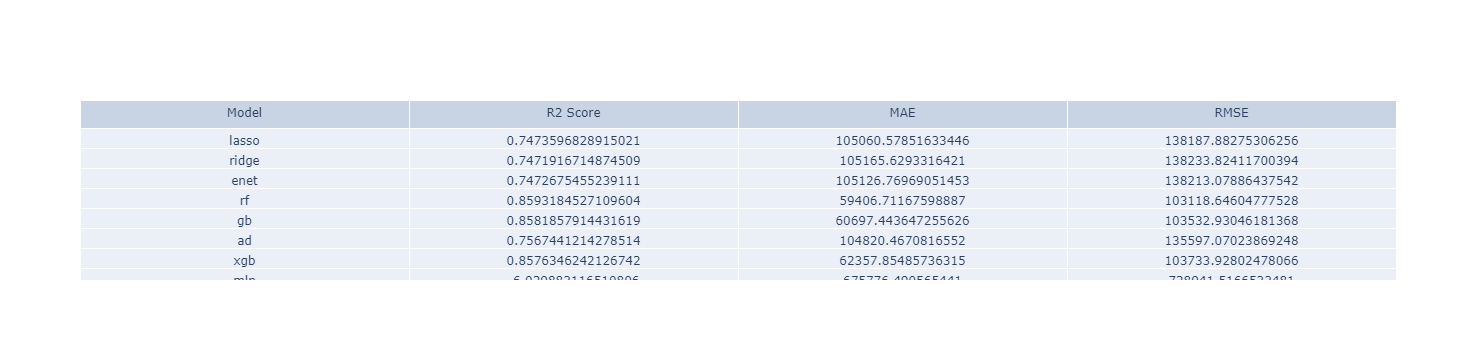

In [63]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=["Model", "R2 Score", "MAE", "RMSE"]),
                 cells=dict(values=[model_list, r2_score_list, mae_list, rmse_list]))
                     ])
fig.show()

**Next, ask yourself these questions to pick the winning model:**

1. Which model had the highest R2 on the test set? **Random Forest**
2. Which model had the lowest mean absolute error? **Random Forest**
3. Are these two models the same one? **Yes**
4. Did it also have the best holdout R2 score from cross-validation? **No**
5. Does it satisfy our project's win condition? (Tip: In the event of ambiguous results based on the previous questions, THIS should be your final deciding factor on whether a model is "good enough.") **Yes**

In [64]:
# import pickle

# # save the model to disk
# filename = 'finalized_model.sav'
# pickle.dump(fitted_model["rf"], open(filename, 'wb'))

### 5.7 Actual Value vs Predicted Value

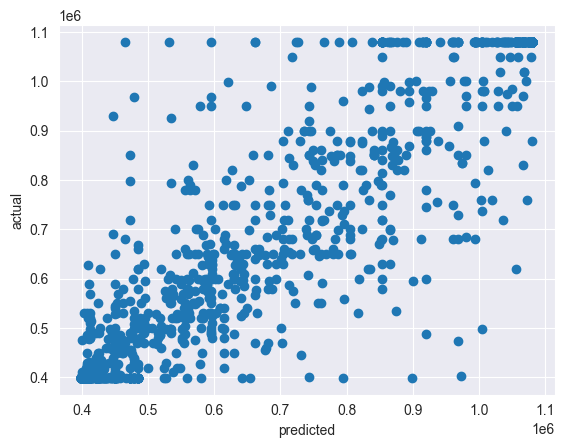

In [65]:
## Random Forest
rf_pred = fitted_model["rf"].predict(X_test)
plt.scatter(rf_pred, y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

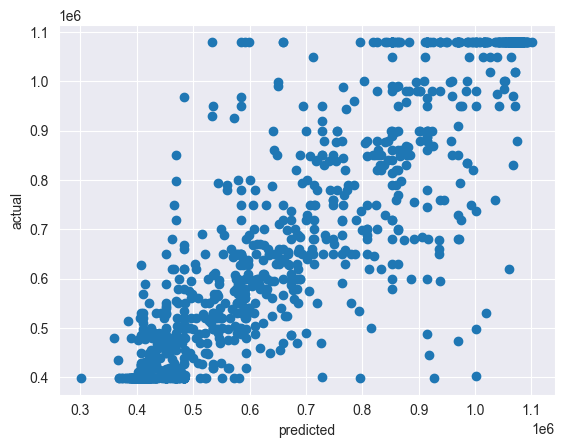

In [66]:
## Gradient Boosting
gb_pred = fitted_model["gb"].predict(X_test)
plt.scatter(gb_pred, y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

## 6.0 Insight & Analysis

**The be**

